In [2]:
from lmfit.models import LinearModel, LorentzianModel
import numpy as np
from astropy.io import fits 
import importlib
import sys
sys.path.append('/home/c2032014/py_files')
import load_and_clean as lac
from stingray import Lightcurve, AveragedCrossspectrum
import matplotlib.pyplot as plt
import scipy


In [3]:
data_12,*_=lac.load_and_clean('/home/c2032014/cygx1_paper/cyg_data_all/03002201/event_1pt5/ixpe03002201_det12_event_1pt5_src.fits', 51,200)
data_3,*_=lac.load_and_clean('/home/c2032014/cygx1_paper/cyg_data_all/03002201/event_1pt5/ixpe03002201_det3_evt_1pt5_v01_src.fits', 51,200)

In [4]:
GTI=np.loadtxt('/home/c2032014/cygx1_paper/cyg_data_all/03002201/GTI_ixpe03002201_evt2_v01.txt')

In [1]:
# Lightcurves
lc_12 = Lightcurve.make_lightcurve(data_12['TIME'], dt=1/64, gti=list(GTI))
lc_12.apply_gtis()
lc_3 = Lightcurve.make_lightcurve(data_3['TIME'], dt=1/64, gti=list(GTI))
lc_3.apply_gtis()

NameError: name 'Lightcurve' is not defined

In [6]:
cs = AveragedCrossspectrum(lc_12, lc_3, 32)
cs=cs.rebin_log(f=0.1)

/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/home/c2032014/.local/lib/python3.10/site-packages/stingray/crossspectrum.py:2912: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(


p0 = [0.05, 0.1, 0.1, 0.59, 0.2425, 0.01, 1.18, 0.485, 0.03, 0.001, 2.5, 0.05]
Best-fit parameters: [0.04558204 0.11596769 0.26081556 0.42372888 0.20051381 0.01721859
 0.84674731 0.42189735 0.01174929 1.29843871 2.94098795 0.00532793]


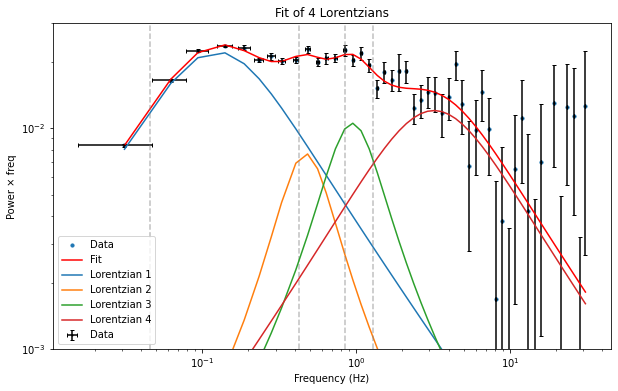

52.80384548291433
Degrees of freedom: 37
Reduced chi-squared: 1.4271309589976846
37


In [17]:
init_centers = [0.05, 1.18/2, 1.18, 0.001]
init_fwhm = [0.2, 0.97/2, 0.97, 5]
init_amplitudes = [0.1, 0.01, 0.03, 0.05]

# Convert FWHM to gamma (gamma = FWHM/2)
init_gamma = [fw/2 for fw in init_fwhm]

# Build p0 = [x01, gamma1, A1, x02, gamma2, A2, ...]
p0 = []
for xc, g, A in zip(init_centers, init_gamma, init_amplitudes):
    p0.extend([xc, g, A])

print("p0 =", p0)



import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a Lorentzian function
def lorentzian(x, x0, gamma, A):
    return (A * (gamma**2)) / ((x - x0)**2 + gamma**2)

# Define the sum of 4 Lorentzians
def four_lorentzians(x, x01, gamma1, A1,
                        x02, gamma2, A2,
                        x03, gamma3, A3,
                        x04, gamma4, A4):
    return (lorentzian(x, x01, gamma1, A1) +
            lorentzian(x, x02, gamma2, A2) +
            lorentzian(x, x03, gamma3, A3) +
            lorentzian(x, x04, gamma4, A4))

# Example: generate some synthetic data

xdata = cs.freq
ydata = cs.power.real

yerr=np.array(np.real(cs.power_err))

# Fit the data
popt, pcov = curve_fit(four_lorentzians, xdata, ydata, p0=p0,sigma=yerr, absolute_sigma=True,maxfev=200000)

# Extract best-fit parameters
print("Best-fit parameters:", popt)

# Plot results
plt.figure(figsize=(10,6))
plt.errorbar(xdata, ydata*xdata, xerr=cs.df/2, yerr=yerr*xdata,color='black' ,fmt='.', markersize=2, capsize=2, label="Data")
plt.scatter(xdata, ydata*xdata, s=10, label="Data")
plt.plot(xdata, four_lorentzians(xdata, *popt)*xdata, 'r-', label="Fit")

# Optionally plot individual Lorentzians
for i in range(4):
    xi, gi, Ai = popt[3*i:3*(i+1)]
    plt.plot(xdata, lorentzian(xdata, xi, gi, Ai)*xdata, '-', label=f"Lorentzian {i+1}")
    plt.axvline(x=xi, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-3,0.03)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power × freq")
plt.title("Fit of 4 Lorentzians")
plt.show()

chi_sqr=np.sum(((ydata - four_lorentzians(xdata, *popt)) / yerr)**2)
print(chi_sqr)

dof=len(ydata)-len(popt)
print("Degrees of freedom:", dof)
print("Reduced chi-squared:", chi_sqr/dof)
print(dof)

In [12]:
yfit = four_lorentzians(xdata, *popt)
xerr=[cs.df/2]*len(xdata)
comp1 = lorentzian(xdata, *popt[0:3])
comp2 = lorentzian(xdata, *popt[3:6])
comp3 = lorentzian(xdata, *popt[6:9])
comp4 = lorentzian(xdata, *popt[9:12])

In [15]:
#Saving out plot data

data_to_save = np.column_stack([
    xdata,           # Frequency
    ydata,           # Original data
    xerr,
    yerr,
    yfit,       # Total fit
    comp1,
    comp2,
    comp3,
    comp4
])

np.savetxt("lorentzian03002201_plt_data.txt", data_to_save,
           header="freq(Hz) power xerr yerr yfit comp1 comp2 comp3 comp4")

print("Data saved to lorentzian03002201_plt_data.txt")

Data saved to lorentzian03002201_plt_data.txt
